In [1]:
from shallue_vanderburg_util.astronet.data.preprocess.preprocess import *
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from lightkurve import *

In [2]:
TCE_DIR = "dr24_tce_full.csv"
KEPLER_DATA_DIR = "../kepler/"
FIG_DIM = (20, 5)
# a 6022556
# b 7978202
KEPID = 6022556

In [3]:
TCE_DIR = "dr24_tce_full.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=159)
tce = tce_df[tce_df.kepid == KEPID].iloc[0]
period = tce["tce_period"]
duration = tce["tce_duration"]
t0 = tce["tce_time0bk"]

In [4]:
all_time, all_flux = read_light_curve(KEPID, KEPLER_DATA_DIR)

6022556


In [5]:
time, flux = process_light_curve(all_time, all_flux)

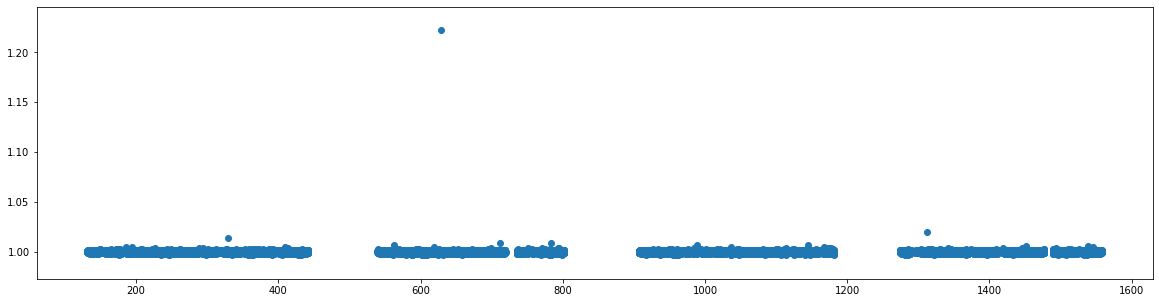

In [6]:
plt.figure(figsize=FIG_DIM)
plt.scatter(time, flux)
plt.show()

In [7]:
folded_time, folded_values = phase_fold_and_sort_light_curve(time, flux, period, t0)

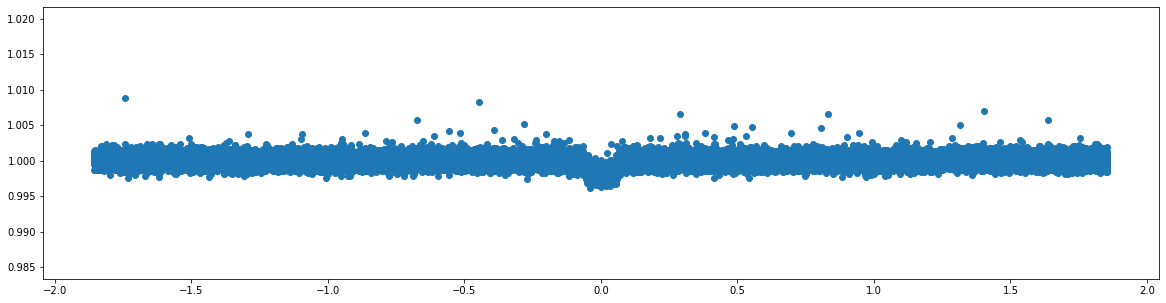

In [8]:
def reject_outliers(data, m = 30.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    mask = s>m
    return np.where(mask, np.nan, data)

plt.figure(figsize=FIG_DIM)
minus_outliers = reject_outliers(folded_values)
plt.scatter(folded_time, minus_outliers)
plt.show()


In [9]:
def scatter_lg(d, t):
    plt.figure(figsize=FIG_DIM)
    plt.scatter(np.arange(-len(d)/2, len(d)/2), d, label="TCE {}".format(KEPID))
    plt.title(t)
    plt.xlabel("Phase-folded datapoints, centered at t0")
    plt.ylabel("Normalized flux")
    plt.legend(loc='upper right')
    plt.show()

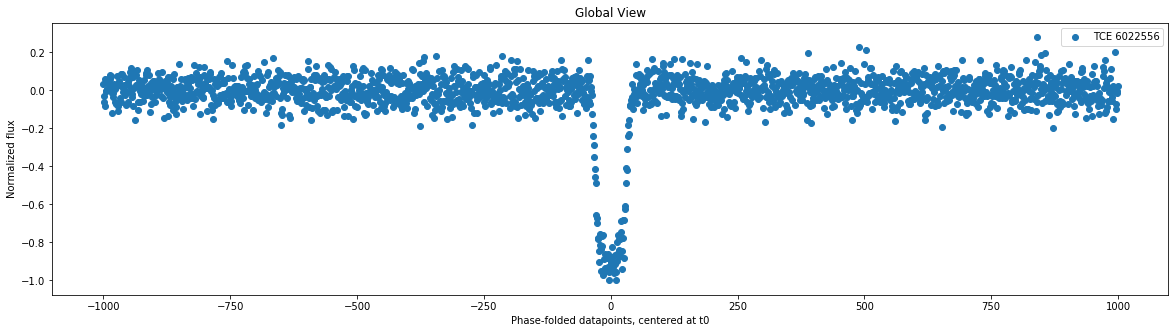

In [10]:
g = global_view(folded_time, folded_values, period)
scatter_lg(g, "Global View")

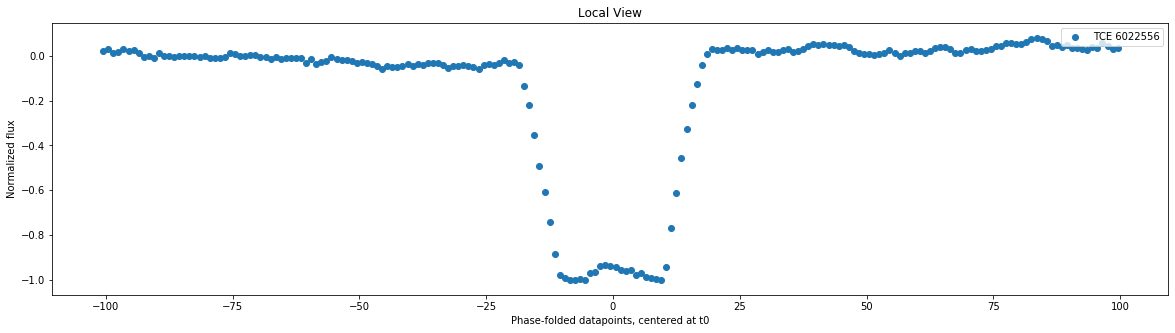

2001


In [16]:
l = local_view(folded_time, folded_values, period, duration)
scatter_lg(l, "Local View")

print(len(g))

In [13]:
import keras 
import numpy as np

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Concatenate, Flatten
from keras.models import Model

# global view input
input_global = Input(shape=(2001,1))
x = Conv1D(16, 5, strides=1)(input_global)
x = Conv1D(16, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(32, 5, strides=1)(x)
x = Conv1D(32, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(64, 5, strides=1)(x)
x = Conv1D(64, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(128, 5, strides=1)(x)
x = Conv1D(128, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(256, 5, strides=1)(x)
x = Conv1D(256, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)

# local view 
input_local = Input(shape=(201,1))
y = Conv1D(16, 5, strides=1)(input_local)
y = Conv1D(16, 5, strides=1)(y)
y = MaxPooling1D(pool_size=7, strides=2)(y)
y = Conv1D(32, 5, strides=1)(y)
y = Conv1D(32, 5, strides=1)(y)
y = MaxPooling1D(pool_size=7, strides=2)(y)

# merge layers for fully connected
xf = Flatten()(x)
yf = Flatten()(y)
z = Concatenate()([xf,yf])
z = Dense(512, activation='relu')(z)
z = Dense(512, activation='relu')(z)
z = Dense(512, activation='relu')(z)

output = Dense(1, activation='sigmoid', name='main_output')(z)

model = Model(inputs=[input_global, input_local], outputs=output)

Using TensorFlow backend.
